# Setting

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import time
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
import os
from calendar import monthrange
!pip install GeoPandas
import geopandas as gpd
from pandas.plotting import scatter_matrix
import datetime as dt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

     |████████████████████████████████| 1.0MB 16.7MB/s 
     |████████████████████████████████| 6.5MB 24.9MB/s 
     |████████████████████████████████| 15.3MB 306kB/s 


# Data Preprocess

In [ ]:
def getTime(t):
  return t[:4] + '-' + t[4:6] + '-' + t[6:8] + ' ' +t[9:11] + ':' + t[11:13] + ':00'

In [ ]:
def wind_sin(t):
  return np.sin(float(t) * np.pi / 180)

In [ ]:
def wind_cos(t):
  return np.cos(float(t) * np.pi / 180)

In [ ]:
def filter_data(data, time):
  data.rename(columns={time: 'timestamp'}, inplace=True)
  data.timestamp = pd.to_datetime(data['timestamp'])
  data = data.sort_values(['timestamp'])
  d1 = '2019-01-01' + ' 00:00:00'
  d2 = '2019-12-31' + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = data[mask].reset_index()
  return data.drop(columns=['index'])

In [ ]:
def filter_data_traffic(data, mon, lat_min, lat_max, lon_min, lon_max):
  data.timestamp = pd.to_datetime(data.timestamp, errors = 'coerce')
  data = data[data['engine_acc'] == 1]
  data = data[data['gpsvalid'] == 1]
  data = data.drop(columns=['gpsvalid', 'engine_acc'])

  # location
  data = data[(data['lat'] <=  lat_max) & (lat_min <= data['lat'])]
  data = data[(data['lon'] <=  lon_max) & (lon_min <= data['lon'])]

  # timestamp
  data.timestamp = pd.to_datetime(data.timestamp)
  data = data.sort_values(["timestamp"])
  i = 1
  d1 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 00:00:00'
  i = monthrange(2019, mon)[-1]
  d2 = '2019-' + str(100+mon)[1:] + '-' + str(100+i)[1:] + ' 23:59:59'
  mask = (data['timestamp'] > pd.Timestamp(d1)) & (data['timestamp'] <= pd.Timestamp(d2))
  data = data[mask]
  return data

In [ ]:
def Extract_points_from_selected_district(mon, radius):
  lat_min = area[radius][0]
  lat_max = area[radius][1]
  lon_min = area[radius][2]
  lon_max = area[radius][3]
  n_days = monthrange(2019, mon)[-1]
  comb = []
  for i in range(1,n_days + 1):
    if (mon == 7 and 16<i and i<22):
      continue
    print('working on'+ str(i))
    G_path = '/content/drive/My Drive/air_polution/PROBE-2019' + str(100+mon)[1:] + '/'
    file_path = G_path + '2019' + str(100+mon)[1:] +str(100 + i)[1:] + '.csv'
    data = pd.read_csv(file_path, header = None, names = ['VehicleID', 'gpsvalid', 'lat', 'lon', 'timestamp', 'speed', 'heading', 'for_hire_light', 'engine_acc'])
    data = filter_data_traffic(data, mon, lat_min, lat_max, lon_min, lon_max)
    comb.append(data)
  out_comb = pd.concat(comb, axis=0)
  out_path = '/content/drive/My Drive/air_polution/filted' + str(100+mon)[1:] + '_' + str(radius) + 'km.csv'
  out_comb.to_csv(out_path, index = False)

In [ ]:
def mergeMonth(start, end, distance):
  frames = []
  for i in range(end - start + 1):
    file_path = '/content/drive/My Drive/air_polution/filted' + str(100+start)[1:] + '_' + str(distance) + 'km.csv'
    data = pd.read_csv(file_path)
    data.timestamp = pd.to_datetime(data.timestamp)
    data['timestamp'] = data['timestamp'].dt.floor('H')
    data = data.groupby('timestamp').agg({'speed':'mean', 'VehicleID':'size'}).rename(columns={'speed':'Avg_speed_'+str(distance)+'km','VehicleID':'num_cars_'+str(distance)+'km'})
    data = data.reset_index()
    frames.append(data)
    start += 1
  data = pd.concat(frames)
  return data

In [ ]:
def incoporateHistoric (colName, H, df):
  for i in range(len(df)):
    result = 0;
    # let the first few row run at first
    if (i <= H):
      if (i == 0):
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = df.loc[df.index[i],colName]
      else:
        for k in range(i):
          row_data = float(df.loc[df.index[k],colName])
          result += row_data
        df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / i
      continue
    
    for j in range(H):
      row_data = float(df.loc[df.index[i-j],colName])
      result += row_data
    df.loc[df.index[i], colName + '(past %s hours average)' % (H)] = result / H

In [ ]:
def timeFilter(t):
  # r = 0
  # hour = t.hour
  # date = t.day
  # month = t.month
  # day = t.dayofweek

  # # mark national holiday first
  # if (((month == 1) and (date == 1)) or ((month == 2) and (date == 19)) or ((month == 4) and (date == 8)) or ((month == 4) and (date == 13)) or ((month == 4) and (date == 14)) or ((month == 4) and (date == 15)) or ((month == 4) and (date == 16))
  #       or ((month == 5) and (date == 1)) or ((month == 5) and (date == 6)) or ((month == 5) and (date == 20)) or ((month == 6) and (date == 3)) or ((month == 7) and (date == 16)) or ((month == 7) and (date == 29)) or ((month == 8) and (date == 12)) 
  #       or ((month == 10) and (date == 14)) or ((month == 10) and (date == 23)) or ((month == 12) and (date == 5)) or ((month == 12) and (date == 10)) or ((month == 12) and (date == 30))):
  #   temp = 2
  # elif (day<=4):
  #   temp = 0
  # else:
  #   temp = 1
  
  # return np.sin(hour * 15 * np.pi / 180.), np.cos(hour * 15 * np.pi / 180.), np.sin(month * 30 * np.pi / 180.), np.cos(month * 30 * np.pi / 180.), temp
  for i in range(len(df)):
    hour = df.loc[df.index[i],'timestamp'].hour
    date = df.loc[df.index[i],'timestamp'].day
    month = df.loc[df.index[i],'timestamp'].month
    day = df.loc[df.index[i],'timestamp'].dayofweek
    df.loc[df.index[i], 'hour of the day (sin)'] = np.sin(hour * 15 * np.pi / 180.)
    df.loc[df.index[i], 'hour of the day (cos)'] = np.cos(hour * 15 * np.pi / 180.)
    df.loc[df.index[i], 'month (sin)'] = np.sin(month * 30 * np.pi / 180.)
    df.loc[df.index[i], 'month (cos)'] = np.cos(month * 30 * np.pi / 180.)
    
    mark national holiday first
    if (((month == 1) and (date == 1)) or ((month == 2) and (date == 19)) or ((month == 4) and (date == 8)) or ((month == 4) and (date == 13)) or ((month == 4) and (date == 14)) or ((month == 4) and (date == 15)) or ((month == 4) and (date == 16))
        or ((month == 5) and (date == 1)) or ((month == 5) and (date == 6)) or ((month == 5) and (date == 20)) or ((month == 6) and (date == 3)) or ((month == 7) and (date == 16)) or ((month == 7) and (date == 29)) or ((month == 8) and (date == 12)) 
        or ((month == 10) and (date == 14)) or ((month == 10) and (date == 23)) or ((month == 12) and (date == 5)) or ((month == 12) and (date == 10)) or ((month == 12) and (date == 30))):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 2
    elif (day<=4):
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 0
    else:
      df.loc[df.index[i], 'type of day (0 = workday, 1 = weekend, 2 = national holiday)'] = 1

In [ ]:
  path = '/content/drive/My Drive/air_polution/'
  air_polution = pd.read_csv('/content/drive/My Drive/air_polution/6.Chulalongkorn-Hospital--Bangkok.csv', header = 0)
  weather = pd.read_csv(path + 'Bangkok_weather_from_19850101.csv', header = 0)
  wind = pd.read_csv(path + 'wind_2019.csv', header = 0)

  # clean the weather
  weather.columns = weather.iloc[8,:]
  weather = weather.drop([0,1,2,3,4,5,6,7,8], axis=0)
  weather['timestamp'] = weather['timestamp'].apply(getTime)
  weather['timestamp'] = pd.to_datetime(weather['timestamp'])

  # transform the wind direction into sin and cos
  wind_prop = ['Bangkok Wind Direction [10 m]', 'Bangkok Wind Direction [80 m]', 'Bangkok Wind Direction [900 mb]', 'Bangkok Wind Direction [850 mb]', 
             'Bangkok Wind Direction [700 mb]', 'Bangkok Wind Direction [500 mb]']
  for i in wind_prop:
    weather[i + '(sin)'] = weather[i].apply(wind_sin)
    weather[i + '(cos)'] = weather[i].apply(wind_cos)

  # limit the time frame
  weather = filter_data(weather,'tiemstamp')
  air_polution = filter_data(air_polution, 'date')
  wind = filter_data(wind, 'local_time')

  # merge the data (wind, air polution, wind)
  data = pd.merge(air_polution, weather, how='inner', on='timestamp', validate='many_to_many')
  data = pd.merge(data, wind, how='inner', on='timestamp', validate='many_to_many')
  # file_path = '/content/drive/My Drive/air_polution/AQI_weather.csv'
  # data.to_csv(file_path, index = False)
  
  # extract the points from selected district
  area = {2:[13.713035, 13.748834, 100.518506, 100.554335], 
        5:[13.686119, 13.776057, 100.490697, 100.583254],
        10:[13.641285, 13.820671, 100.444445, 100.629641]}
  months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  for month in months:
    for i in area.keys():
      Extract_points_from_selected_district(month, i)

  # preprocess the traffic data in 2, 5, 10 km
  data_2km = mergeMonth(1, 12, 2)
  data_5km = mergeMonth(1, 12, 5)
  data_10km = mergeMonth(1, 12, 10)

  # concat all to current data frames
  data = pd.merge(data_2km,data_5km,how='inner',on='timestamp',validate='many_to_many')
  data = pd.merge(data,data_10km,how='inner',on='timestamp',validate='many_to_many')
  # out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all.csv'
  # data.to_csv(out_path, index = False)

  # incorporate historical data
  cols = data.columns
  for col in cols:
    if (col == 'timestamp'):
      continue
    incoporateHistoric(col, 3, data)
    incoporateHistoric(col, 8, data)
    incoporateHistoric(col, 24, data)
    incoporateHistoric(col, 48, data)
  # out_path = '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic.csv'
  # data.to_csv(out_path, index = False)

  # transform time filter
  timeFilter(data)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Loading

In [4]:
file_path_merge_May_Sep_5km =  '/content/drive/My Drive/air_polution/merge_May_Dec_all_historic_aqiTime_deleteCopied.csv'
data = pd.read_csv(file_path_merge_May_Sep_5km)
data = data.drop(columns=['timestamp'])

# EDA

In [ ]:
na_num = data[data.isnull().any(axis=1)].shape[0]
na_percent = na_num / data.shape[0]
print('There are ' + str(na_num) + ' rows having na (' + str(round(na_percent, 2)) + ' of sample size) in data')

There are 0 rows having na (0.0 of sample size) in data


In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

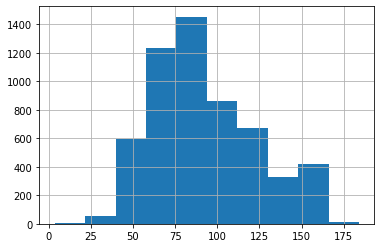

In [ ]:
data['aqi'].hist()

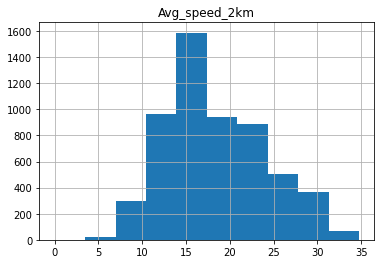

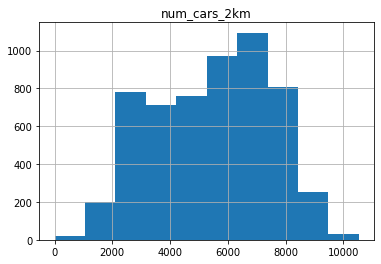

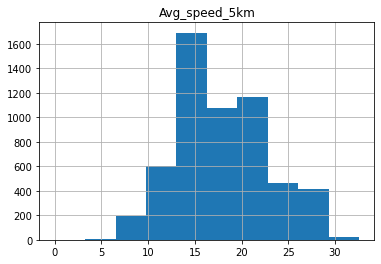

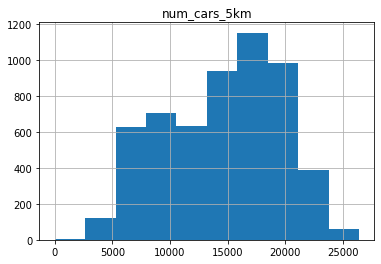

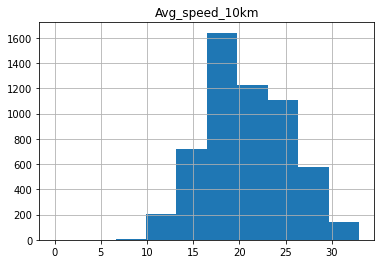

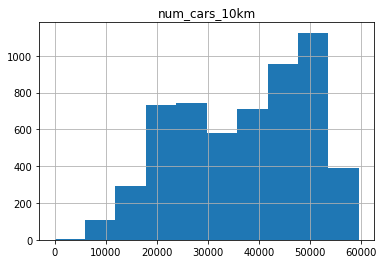

In [ ]:
lis = ['Avg_speed_2km', 'num_cars_2km', 'Avg_speed_5km', 'num_cars_5km', 'Avg_speed_10km', 'num_cars_10km']
for i in lis:
  data[i].hist()
  plt.title(i)
  plt.show()

# PDA

## AQI

### Data splitting and data preprocessing

In [ ]:
y = data['aqi']
x = data.drop(columns=['aqi'])
n = 0.8
val_n = n + 0.1
rows = x.shape[0]
train_x, val_x, test_x = x[:int(n * rows)], x[int(n * rows) : int(val_n * rows)], x[int(val_n * rows) :]
train_y, val_y, test_y = y[:int(n * rows)], y[int(n * rows) : int(val_n * rows)], y[int(val_n * rows) :]

numerical_cols = [c for c in x.columns if data[c].dtype in ['int64', 'float64'] and c != 'type of day (0 = workday, 1 = weekend, 2 = national holiday)']
# categorical_cols = [c for c in x.columns if data[c].dtype == 'object']
categorical_cols = ['type of day (0 = workday, 1 = weekend, 2 = national holiday)']

numerical_transformer = Pipeline(steps=[
     ('Standardization', StandardScaler())                                   
])
categorical_transformer = Pipeline(steps=[
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
          ('numerical', numerical_transformer, numerical_cols),
          ('categorical', categorical_transformer, categorical_cols)
])

train_x = preprocessor.fit_transform(train_x)
val_x = preprocessor.transform(val_x)
test_x = preprocessor.transform(test_x)

NameError: ignored

### Model training

### Basic Model

In [ ]:
# Spot Check Algorithms
models = []
models.append(('Lasso', linear_model.Lasso(alpha=0.5, max_iter=10000)))
models.append(('RF', RandomForestRegressor(max_depth=8)))
models.append(('Boosting', GradientBoostingRegressor(max_depth=8)))
models.append(('SVR', SVR(C=10)))
models.append(('DNN', MLPRegressor(hidden_layer_sizes=(50,50,30,30,10), activation='relu', early_stopping=True, batch_size=128, max_iter=1000, verbose=False)))
# evaluate each model in turn
R2_results = []
RMSE_results = []
names = []
tscv = TimeSeriesSplit(n_splits=10)
for name, model in models:
  scores = []
  RMSE = []
  for train_index, test_index in tscv.split(train_x):
      X_train, X_test = train_x[train_index], train_x[test_index]
      y_train, y_test = train_y[train_index], train_y[test_index]
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      scores.append(r2_score(y_test, y_pred))
      RMSE.append(mean_squared_error(y_test, y_pred))
      names.append(name)
  R2_results.append(scores)
  RMSE_results.append(RMSE)
  scores = np.array(scores)
  RMSE = np.array(RMSE)
  print('%s R2: %f (%f)' % (name, scores.mean(), scores.std()))
  print('%s RMSE: %f (%f)' % (name, RMSE.mean(), RMSE.std()))

In [ ]:
plt.boxplot(R2_results, labels=['Lasso', 'RF', 'Boosting', 'SVR', 'DNN'])
plt.title('Algorithm Comparison (R2)')
plt.ylim(0,1)
plt.show()

In [ ]:
plt.boxplot(RMSE_results, labels=['Lasso', 'RF', 'Boosting', 'SVR', 'DNN'])
plt.title('Algorithm Comparison (RMSE)')
plt.ylim(0, 2000)
plt.show()

# Deep Learning

Ref: https://www.tensorflow.org/tutorials/structured_data/time_series

In [5]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

In [6]:
# 1. input time width, label time width, shift time, total window size = input width + shift time
# 2. Generate data: convert array [0, 1, 2, 3] into [[0, 1, 2], [1, 2, 3]] using ds = tf.keras.preprocessing.timeseries_dataset_from_array with total window size
# 3. feed the output of 2 to generate the input data and label data for training and validation purpose
# EX if label width = 3 input width = 3, shift = 3. Then [1, 2, 3, 4, 5, 6, 7, 8, 9] will become input [1, 2, 3], [2, 3, 4], [4, 5, 6].... and lable [4, 5, 6], [5, 6, 7].. 
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    # split the features into input part and labels part
  def split_window(self, features):
    # batch size, time, features
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
      
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])  

    return inputs, labels

  def plot(self, model=None, plot_col='num_cars_2km', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # convert array [0, 1, 2, 3] into [[0, 1, 2], [1, 2, 3]]
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=64,)
    # map each element to split window function
    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [10]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=500,
    decay_rate=0.9)
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate= lr_schedule),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      # ,callbacks=[early_stopping])
  return history

## Future single step prediction (one to one and many to one, next one hour)

In [ ]:
# input time step, label time step, shift next x hour prediction
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['num_cars_2km'])
single_step_window.train

<MapDataset shapes: ((None, 1, 261), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(2):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 261)
Labels shape (batch, time, features): (64, 1, 1)
Inputs shape (batch, time, features): (64, 1, 261)
Labels shape (batch, time, features): (64, 1, 1)


In [ ]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['num_cars_2km']

### Linear Model

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=50)
])

In [ ]:
history = compile_and_fit(linear, single_step_window)

performance = {}
val_performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/30
62/62 [==============================] - 1s 10ms/step - loss: 0.0887 - mean_absolute_error: 0.2261 - val_loss: 0.1543 - val_mean_absolute_error: 0.2951
Epoch 2/30
62/62 [==============================] - 1s 8ms/step - loss: 0.0912 - mean_absolute_error: 0.2299 - val_loss: 0.1613 - val_mean_absolute_error: 0.3057
Epoch 3/30
62/62 [==============================] - 0s 8ms/step - loss: 0.1072 - mean_absolute_error: 0.2526 - val_loss: 0.1620 - val_mean_absolute_error: 0.3059
Epoch 4/30
62/62 [==============================] - 0s 7ms/step - loss: 0.1320 - mean_absolute_error: 0.2783 - val_loss: 0.1666 - val_mean_absolute_error: 0.3100
Epoch 5/30
62/62 [==============================] - 1s 8ms/step - loss: 0.1523 - mean_absolute_error: 0.3000 - val_loss: 0.1652 - val_mean_absolute_error: 0.3077
Epoch 6/30
62/62 [==============================] - 0s 8ms/step - loss: 0.1318 - mean_absolute_error: 0.2772 - val_loss: 0.1525 - val_mean_absolute_error: 0.2940
Epoch 7/30
62/62 [=========

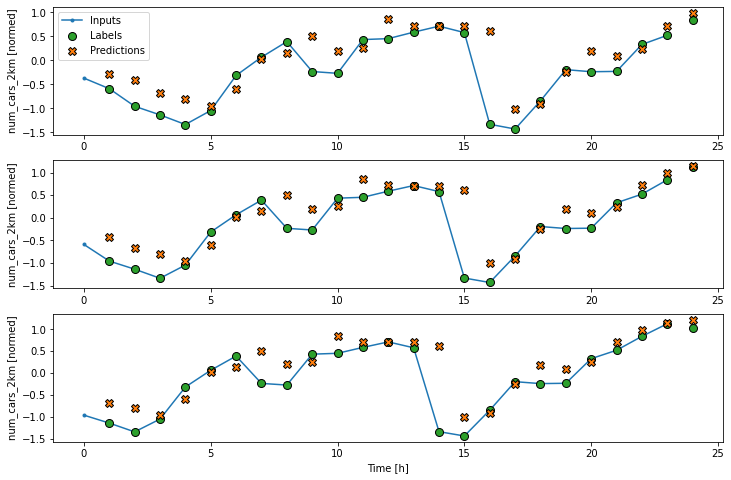

In [ ]:
wide_window.plot(linear)

### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/30
62/62 [==============================] - 2s 14ms/step - loss: 0.4682 - mean_absolute_error: 0.5481 - val_loss: 0.4911 - val_mean_absolute_error: 0.5666
Epoch 2/30
62/62 [==============================] - 1s 10ms/step - loss: 0.2678 - mean_absolute_error: 0.4227 - val_loss: 0.1795 - val_mean_absolute_error: 0.3346
Epoch 3/30
62/62 [==============================] - 1s 10ms/step - loss: 0.1982 - mean_absolute_error: 0.3532 - val_loss: 0.1656 - val_mean_absolute_error: 0.3264
Epoch 4/30
62/62 [==============================] - 1s 9ms/step - loss: 0.1821 - mean_absolute_error: 0.3417 - val_loss: 0.1389 - val_mean_absolute_error: 0.2882
Epoch 5/30
62/62 [==============================] - 1s 10ms/step - loss: 0.1238 - mean_absolute_error: 0.2721 - val_loss: 0.1605 - val_mean_absolute_error: 0.3175
Epoch 6/30
62/62 [==============================] - 1s 9ms/step - loss: 0.1174 - mean_absolute_error: 0.2602 - val_loss: 0.1303 - val_mean_absolute_error: 0.2779
Epoch 7/30
62/62 [======

In [ ]:
wide_window.plot(dense)

### CNN

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['num_cars_2km'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['num_cars_2km']

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Conv'] = multi_step_dense.evaluate(conv_window.val)
performance['Conv'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/30
62/62 [==============================] - 1s 12ms/step - loss: 0.0514 - mean_absolute_error: 0.1706 - val_loss: 0.1080 - val_mean_absolute_error: 0.2453
Epoch 2/30
62/62 [==============================] - 1s 9ms/step - loss: 0.0720 - mean_absolute_error: 0.2071 - val_loss: 0.2331 - val_mean_absolute_error: 0.3677
Epoch 3/30
62/62 [==============================] - 1s 10ms/step - loss: 0.1274 - mean_absolute_error: 0.2795 - val_loss: 0.1026 - val_mean_absolute_error: 0.2453
Epoch 4/30
62/62 [==============================] - 1s 9ms/step - loss: 0.0971 - mean_absolute_error: 0.2390 - val_loss: 0.1385 - val_mean_absolute_error: 0.2850
Epoch 5/30
62/62 [==============================] - 1s 10ms/step - loss: 0.1958 - mean_absolute_error: 0.3174 - val_loss: 0.1369 - val_mean_absolute_error: 0.2861
Epoch 6/30
62/62 [==============================] - 1s 9ms/step - loss: 0.0784 - mean_absolute_error: 0.2177 - val_loss: 0.1418 - val_mean_absolute_error: 0.2890
Epoch 7/30
62/62 [=======

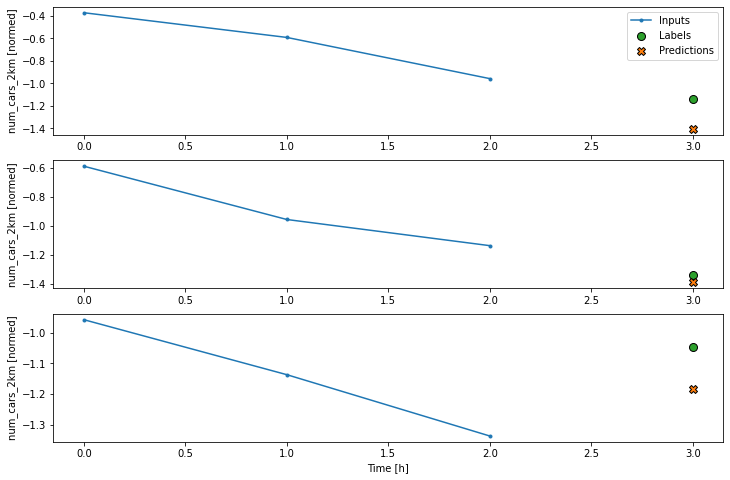

In [ ]:
conv_window.plot(multi_step_dense)

### RNN

In [ ]:
LABEL_WIDTH = 24
wide_window = WindowGenerator(
    input_width=LABEL_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['num_cars_2km'])

wide_window

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=1)

Epoch 1/30
62/62 [==============================] - 11s 107ms/step - loss: 0.6004 - mean_absolute_error: 0.6227 - val_loss: 0.4752 - val_mean_absolute_error: 0.5337
Epoch 2/30
62/62 [==============================] - 6s 93ms/step - loss: 0.2533 - mean_absolute_error: 0.3965 - val_loss: 0.1939 - val_mean_absolute_error: 0.3430
Epoch 3/30
62/62 [==============================] - 6s 93ms/step - loss: 0.2182 - mean_absolute_error: 0.3637 - val_loss: 0.1668 - val_mean_absolute_error: 0.3163
Epoch 4/30
62/62 [==============================] - 6s 93ms/step - loss: 0.1567 - mean_absolute_error: 0.3054 - val_loss: 0.1516 - val_mean_absolute_error: 0.3097
Epoch 5/30
62/62 [==============================] - 6s 93ms/step - loss: 0.1423 - mean_absolute_error: 0.2864 - val_loss: 0.1857 - val_mean_absolute_error: 0.3382
Epoch 6/30
62/62 [==============================] - 6s 92ms/step - loss: 0.1247 - mean_absolute_error: 0.2701 - val_loss: 0.1370 - val_mean_absolute_error: 0.2889
Epoch 7/30
62/62 [==

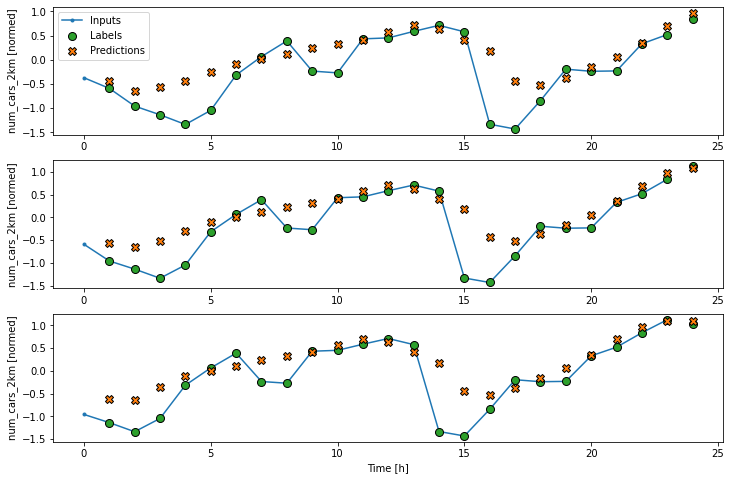

In [ ]:
wide_window.plot(lstm_model)

### Comparison

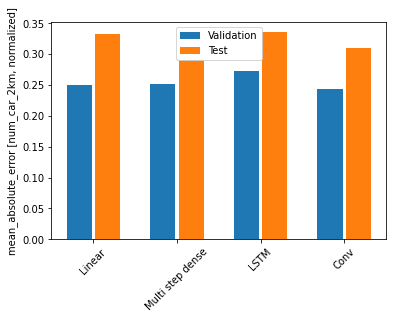

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [num_car_2km, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Linear      : 0.3317
Multi step dense: 0.2894
LSTM        : 0.3351
Conv        : 0.3094


Interestingly, LSTM not necessarily performs best in this scenario. 

### Multiple output
output multiple features at a time

In [ ]:
features = ['num_cars_2km', 'num_cars_5km', 'num_cars_10km', 'Avg_speed_2km', 'Avg_speed_5km', 'Avg_speed_10km', 'aqi']

# for DNN
narrow_window = WindowGenerator(input_width=1, label_width=1, shift=1, 
                              label_columns= features)
# for Rnn and resnet
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 261)
Labels shape (batch, time, features): (64, 24, 261)


#### DNN

In [ ]:
# DNN
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=128, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(units=32, activation='tanh'),
    tf.keras.layers.Dense(units=len(features))
])

history = compile_and_fit(dense, narrow_window)

val_performance['Dense'] = dense.evaluate(narrow_window.val)
performance['Dense'] = dense.evaluate(narrow_window.test, verbose=1)

Epoch 1/30
62/62 [==============================] - 2s 15ms/step - loss: 0.5548 - mean_absolute_error: 0.5782 - val_loss: 0.6484 - val_mean_absolute_error: 0.6346
Epoch 2/30
62/62 [==============================] - 1s 10ms/step - loss: 0.3709 - mean_absolute_error: 0.4647 - val_loss: 0.3207 - val_mean_absolute_error: 0.4290
Epoch 3/30
62/62 [==============================] - 1s 10ms/step - loss: 0.2817 - mean_absolute_error: 0.4094 - val_loss: 0.3037 - val_mean_absolute_error: 0.4164
Epoch 4/30
62/62 [==============================] - 1s 10ms/step - loss: 0.2191 - mean_absolute_error: 0.3495 - val_loss: 0.2693 - val_mean_absolute_error: 0.3908
Epoch 5/30
62/62 [==============================] - 1s 10ms/step - loss: 0.2257 - mean_absolute_error: 0.3571 - val_loss: 0.2698 - val_mean_absolute_error: 0.3851
Epoch 6/30
62/62 [==============================] - 1s 9ms/step - loss: 0.1692 - mean_absolute_error: 0.3046 - val_loss: 0.3365 - val_mean_absolute_error: 0.4421
Epoch 7/30
62/62 [=====

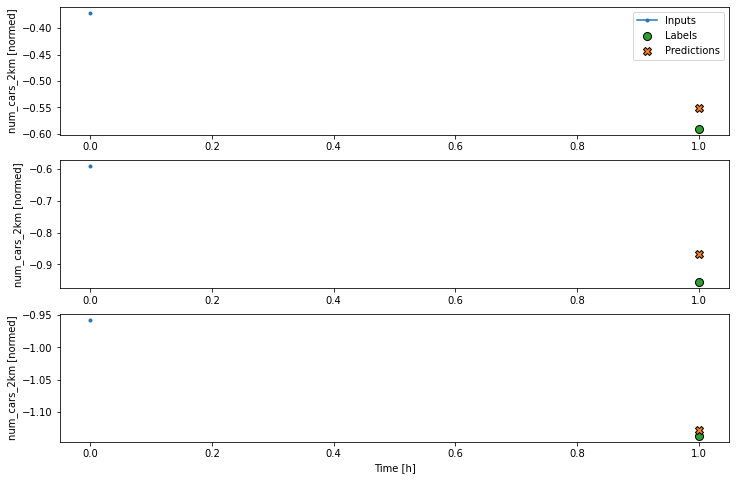

In [ ]:
narrow_window.plot(dense)

#### RNN

In [ ]:
# RNN
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=261)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=1)

Epoch 1/30
62/62 [==============================] - 12s 128ms/step - loss: 0.9558 - mean_absolute_error: 0.7654 - val_loss: 1.4884 - val_mean_absolute_error: 0.9572
Epoch 2/30
62/62 [==============================] - 7s 114ms/step - loss: 0.6939 - mean_absolute_error: 0.6368 - val_loss: 1.2191 - val_mean_absolute_error: 0.8302
Epoch 3/30
62/62 [==============================] - 7s 114ms/step - loss: 0.5530 - mean_absolute_error: 0.5688 - val_loss: 1.1119 - val_mean_absolute_error: 0.7832
Epoch 4/30
62/62 [==============================] - 7s 114ms/step - loss: 0.4627 - mean_absolute_error: 0.5127 - val_loss: 1.0311 - val_mean_absolute_error: 0.7503
Epoch 5/30
62/62 [==============================] - 7s 114ms/step - loss: 0.4283 - mean_absolute_error: 0.4933 - val_loss: 0.9881 - val_mean_absolute_error: 0.7258
Epoch 6/30
62/62 [==============================] - 7s 113ms/step - loss: 0.3853 - mean_absolute_error: 0.4676 - val_loss: 0.9333 - val_mean_absolute_error: 0.7035
Epoch 7/30
62/6

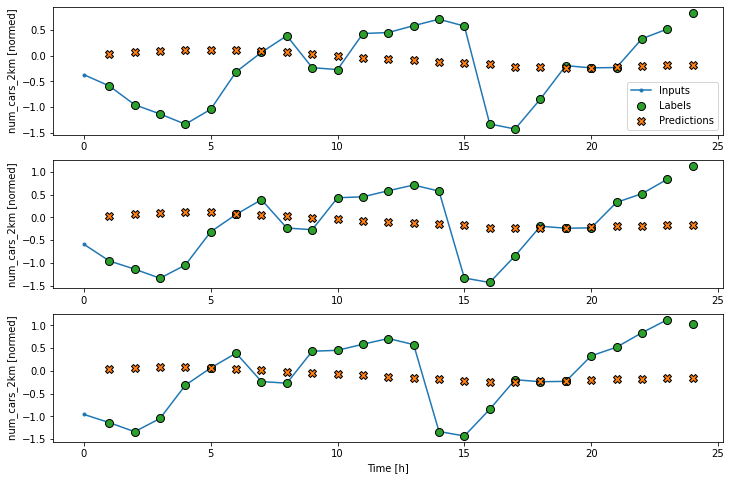

In [ ]:
wide_window.plot(lstm_model)

#### Advanced: Residual connections

While we look closer, the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

**It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.**

Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

Resnet Diagram
![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

In [16]:
# ResNet
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta (the small change in time series analysis)
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(
        261,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/30
62/62 [==============================] - 6s 66ms/step - loss: 0.0415 - mean_absolute_error: 0.1019 - val_loss: 0.0373 - val_mean_absolute_error: 0.1001
Epoch 2/30
62/62 [==============================] - 3s 54ms/step - loss: 0.0348 - mean_absolute_error: 0.0935 - val_loss: 0.0344 - val_mean_absolute_error: 0.0944
Epoch 3/30
62/62 [==============================] - 3s 53ms/step - loss: 0.0321 - mean_absolute_error: 0.0873 - val_loss: 0.0322 - val_mean_absolute_error: 0.0917
Epoch 4/30
62/62 [==============================] - 3s 53ms/step - loss: 0.0302 - mean_absolute_error: 0.0845 - val_loss: 0.0311 - val_mean_absolute_error: 0.0904
Epoch 5/30
62/62 [==============================] - 3s 53ms/step - loss: 0.0283 - mean_absolute_error: 0.0812 - val_loss: 0.0305 - val_mean_absolute_error: 0.0899
Epoch 6/30
62/62 [==============================] - 3s 53ms/step - loss: 0.0271 - mean_absolute_error: 0.0798 - val_loss: 0.0300 - val_mean_absolute_error: 0.0891
Epoch 7/30
62/62 [====

#### Performance

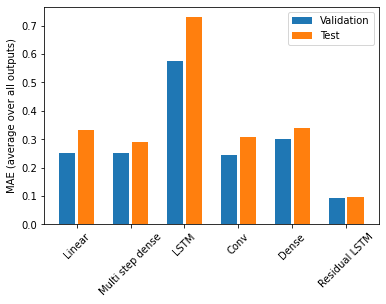

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Linear         : 0.3317
Multi step dense: 0.2894
LSTM           : 0.7301
Conv           : 0.3094
Dense          : 0.3394
Residual LSTM  : 0.0968


## Future Multi-step prediction (many to many, next many hours)

In previous section, we trying to predict 1h into the future. The section will learn to predict a range of future values (a sequence of the future values)

In [7]:
train_df

,Avg_speed_2km,num_cars_2km,Avg_speed_5km,num_cars_5km,Avg_speed_10km,num_cars_10km,aqi,Bangkok Temperature [2 m elevation corrected],Bangkok Relative Humidity [2 m],Bangkok Mean Sea Level Pressure [MSL],Bangkok Precipitation Total,Bangkok Cloud Cover Total,Bangkok Sunshine Duration,Bangkok Shortwave Radiation,Bangkok Direct Shortwave Radiation,Bangkok Diffuse Shortwave Radiation,Bangkok Evapotranspiration,Bangkok FAO Reference Evapotranspiration [2 m],Bangkok CAPE [180-0 mb above gnd],Bangkok Wind Gust,Bangkok Wind Speed [10 m],Bangkok Wind Speed [80 m],Bangkok Wind Speed [900 mb],Bangkok Wind Speed [850 mb],Bangkok Wind Speed [700 mb],Bangkok Wind Speed [500 mb],Bangkok Geopotential Height [1000 mb],Bangkok Geopotential Height [850 mb],Bangkok Geopotential Height [700 mb],Bangkok Geopotential Height [500 mb],Bangkok Temperature [1000 mb],Bangkok Temperature [850 mb],Bangkok Temperature [700 mb],Bangkok Temperature,Bangkok Soil Temperature [0-10 cm down],Bangkok Soil Moisture [0-10 cm down],Bangkok Vapor Pressure Deficit [2 m],Bangkok Wind Direction [10 m](sin),Bangkok Wind Direction [10 m](cos),Bangkok Wind Direction [80 m](sin),...,Bangkok Wind Direction [900 mb](cos)(past 24 hours average),Bangkok Wind Direction [900 mb](cos)(past 48 hours average),Bangkok Wind Direction [850 mb](sin)(past 3 hours average),Bangkok Wind Direction [850 mb](sin)(past 8 hours average),Bangkok Wind Direction [850 mb](sin)(past 24 hours average),Bangkok Wind Direction [850 mb](sin)(past 48 hours average),Bangkok Wind Direction [850 mb](cos)(past 3 hours average),Bangkok Wind Direction [850 mb](cos)(past 8 hours average),Bangkok Wind Direction [850 mb](cos)(past 24 hours average),Bangkok Wind Direction [850 mb](cos)(past 48 hours average),Bangkok Wind Direction [700 mb](sin)(past 3 hours average),Bangkok Wind Direction [700 mb](sin)(past 8 hours average),Bangkok Wind Direction [700 mb](sin)(past 24 hours average),Bangkok Wind Direction [700 mb](sin)(past 48 hours average),Bangkok Wind Direction [700 mb](cos)(past 3 hours average),Bangkok Wind Direction [700 mb](cos)(past 8 hours average),Bangkok Wind Direction [700 mb](cos)(past 24 hours average),Bangkok Wind Direction [700 mb](cos)(past 48 hours average),Bangkok Wind Direction [500 mb](sin)(past 3 hours average),Bangkok Wind Direction [500 mb](sin)(past 8 hours average),Bangkok Wind Direction [500 mb](sin)(past 24 hours average),Bangkok Wind Direction [500 mb](sin)(past 48 hours average),Bangkok Wind Direction [500 mb](cos)(past 3 hours average),Bangkok Wind Direction [500 mb](cos)(past 8 hours average),Bangkok Wind Direction [500 mb](cos)(past 24 hours average),Bangkok Wind Direction [500 mb](cos)(past 48 hours average),electricity(past 3 hours average),electricity(past 8 hours average),electricity(past 24 hours average),electricity(past 48 hours average),wind_speed(past 3 hours average),wind_speed(past 8 hours average),wind_speed(past 24 hours average),wind_speed(past 48 hours average),hour of the day (sin),hour of the day (cos),month (sin),month (cos),"type of day (0 = workday, 1 = weekend, 2 = national holiday)",aqi(past 168 hours average)
0,0.946921,-0.370889,0.621011,-0.183970,0.841283,-0.373509,-0.258475,0.346845,-0.296209,0.399297,-0.318816,0.742610,-0.434209,-0.703549,-0.471857,-0.800871,-0.777872,-0.550694,1.388279,-0.384634,0.459657,0.695991,-0.629875,-0.818124,-1.217939,-0.606397,0.412746,0.903246,1.538905,1.315118,0.353376,3.045080,1.662189,0.051313,1.239304,-2.655625,0.159663,0.572917,-0.704397,0.667733,...,-1.005683,-1.059054,-0.276679,-0.277376,-0.277519,-0.275289,-1.801732,-1.887999,-2.103853,-2.283171,0.574664,0.580916,0.598696,0.622201,-2.043956,-2.108981,-2.265802,-2.436829,0.830578,0.855495,0.918489,0.988329,1.070554,1.118232,1.251886,1.413838,-0.390234,-0.440316,-0.587963,-0.613368,-0.174439,-0.193165,-0.234299,-0.242215,-0.001633,1.416446,1.662475,-0.712385,2.851236,-0.414647
1,1.072427,-0.590659,1.153204,-0.535392,1.275537,-0.657373,-0.829850,0.301042,-0.221402,0.314607,-

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

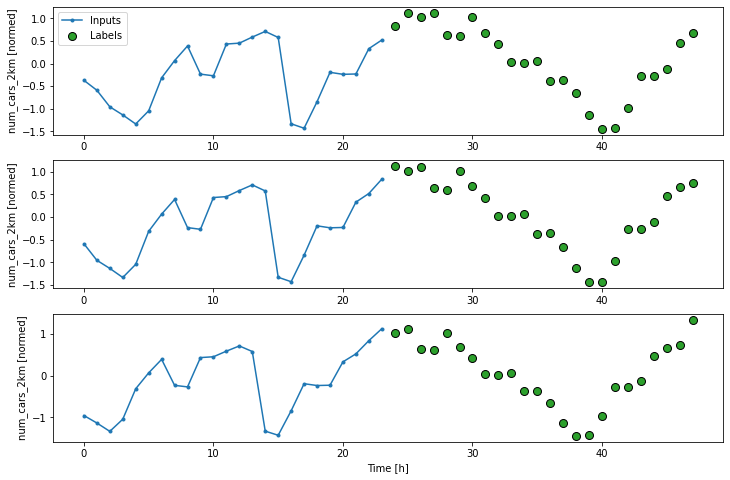

In [8]:
OUT_STEPS = 24
num_features = 261
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Baseline 

It takes the last time-step to predict next 24h. Note: it product out_steps * num_features prediction, so we then transform it into (outsteps (24), num_features(7))

Epoch 1/30
61/61 [==============================] - 3s 35ms/step - loss: 0.7032 - mean_absolute_error: 0.6380 - val_loss: 0.8655 - val_mean_absolute_error: 0.6790
Epoch 2/30
61/61 [==============================] - 2s 32ms/step - loss: 0.3705 - mean_absolute_error: 0.4566 - val_loss: 0.7165 - val_mean_absolute_error: 0.6098
Epoch 3/30
61/61 [==============================] - 2s 32ms/step - loss: 0.2903 - mean_absolute_error: 0.3956 - val_loss: 0.6346 - val_mean_absolute_error: 0.5681
Epoch 4/30
61/61 [==============================] - 2s 31ms/step - loss: 0.2625 - mean_absolute_error: 0.3712 - val_loss: 0.5877 - val_mean_absolute_error: 0.5437
Epoch 5/30
61/61 [==============================] - 2s 33ms/step - loss: 0.2440 - mean_absolute_error: 0.3538 - val_loss: 0.5574 - val_mean_absolute_error: 0.5273
Epoch 6/30
61/61 [==============================] - 2s 32ms/step - loss: 0.2317 - mean_absolute_error: 0.3420 - val_loss: 0.5367 - val_mean_absolute_error: 0.5153
Epoch 7/30
61/61 [====

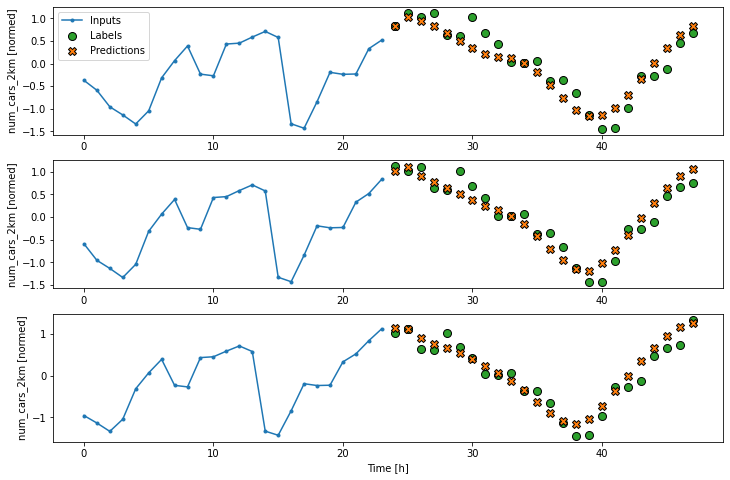

In [11]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### DNN

Epoch 1/30
61/61 [==============================] - 3s 33ms/step - loss: 0.8830 - mean_absolute_error: 0.7328 - val_loss: 1.8952 - val_mean_absolute_error: 1.1035
Epoch 2/30
61/61 [==============================] - 2s 27ms/step - loss: 0.8342 - mean_absolute_error: 0.7118 - val_loss: 1.2736 - val_mean_absolute_error: 0.8566
Epoch 3/30
61/61 [==============================] - 2s 28ms/step - loss: 0.7299 - mean_absolute_error: 0.6603 - val_loss: 1.2010 - val_mean_absolute_error: 0.8191
Epoch 4/30
61/61 [==============================] - 2s 28ms/step - loss: 0.6570 - mean_absolute_error: 0.6250 - val_loss: 1.1912 - val_mean_absolute_error: 0.8136
Epoch 5/30
61/61 [==============================] - 2s 28ms/step - loss: 0.5974 - mean_absolute_error: 0.5973 - val_loss: 1.2042 - val_mean_absolute_error: 0.8236
Epoch 6/30
61/61 [==============================] - 2s 27ms/step - loss: 0.5712 - mean_absolute_error: 0.5868 - val_loss: 1.1278 - val_mean_absolute_error: 0.7873
Epoch 7/30
61/61 [====

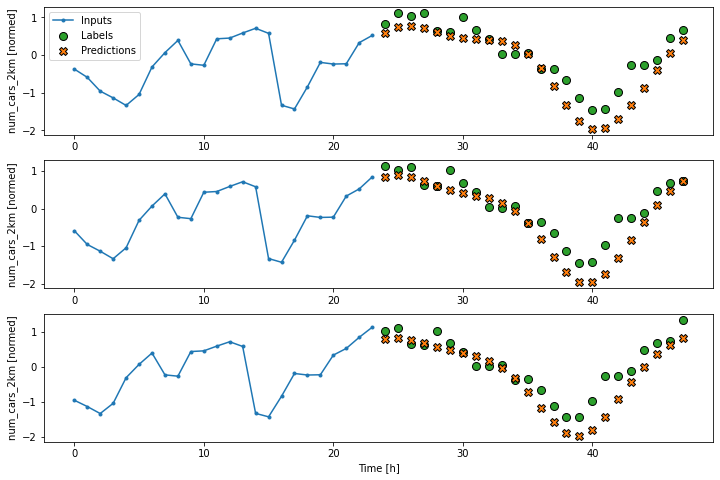

In [12]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

CNN makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time.

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

Epoch 1/30
61/61 [==============================] - 3s 47ms/step - loss: 0.7784 - mean_absolute_error: 0.6721 - val_loss: 1.0411 - val_mean_absolute_error: 0.7706
Epoch 2/30
61/61 [==============================] - 3s 41ms/step - loss: 1.1176 - mean_absolute_error: 0.7662 - val_loss: 1.0858 - val_mean_absolute_error: 0.7804
Epoch 3/30
61/61 [==============================] - 3s 42ms/step - loss: 0.5289 - mean_absolute_error: 0.5545 - val_loss: 1.0119 - val_mean_absolute_error: 0.7524
Epoch 4/30
61/61 [==============================] - 3s 43ms/step - loss: 0.5011 - mean_absolute_error: 0.5432 - val_loss: 1.0199 - val_mean_absolute_error: 0.7700
Epoch 5/30
61/61 [==============================] - 3s 43ms/step - loss: 0.5267 - mean_absolute_error: 0.5508 - val_loss: 0.8368 - val_mean_absolute_error: 0.6774
Epoch 6/30
61/61 [==============================] - 3s 42ms/step - loss: 0.3493 - mean_absolute_error: 0.4434 - val_loss: 0.8185 - val_mean_absolute_error: 0.6708
Epoch 7/30
61/61 [====

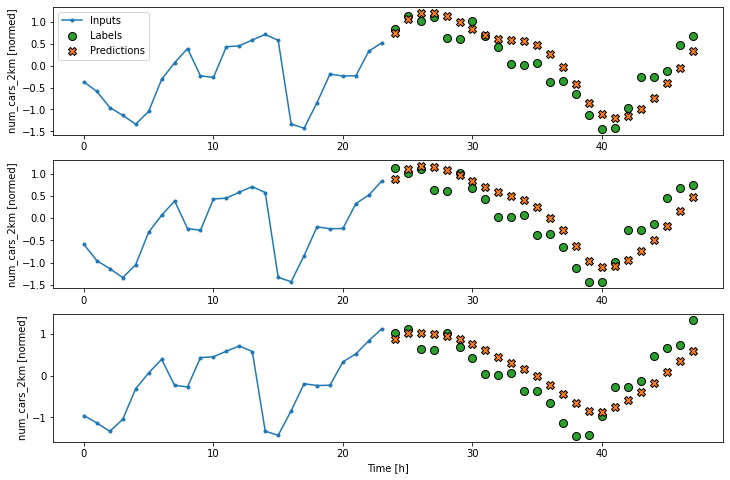

In [13]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)


multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)

Epoch 1/30
61/61 [==============================] - 16s 211ms/step - loss: 0.8241 - mean_absolute_error: 0.7018 - val_loss: 1.2368 - val_mean_absolute_error: 0.8426
Epoch 2/30
61/61 [==============================] - 12s 199ms/step - loss: 0.6017 - mean_absolute_error: 0.5869 - val_loss: 1.1023 - val_mean_absolute_error: 0.7732
Epoch 3/30
61/61 [==============================] - 12s 201ms/step - loss: 0.4296 - mean_absolute_error: 0.4946 - val_loss: 0.9427 - val_mean_absolute_error: 0.7075
Epoch 4/30
61/61 [==============================] - 13s 216ms/step - loss: 0.3552 - mean_absolute_error: 0.4444 - val_loss: 0.8899 - val_mean_absolute_error: 0.6827
Epoch 5/30
61/61 [==============================] - 13s 212ms/step - loss: 0.3282 - mean_absolute_error: 0.4265 - val_loss: 0.8638 - val_mean_absolute_error: 0.6698
Epoch 6/30
61/61 [==============================] - 12s 200ms/step - loss: 0.2918 - mean_absolute_error: 0.3970 - val_loss: 0.8221 - val_mean_absolute_error: 0.6512
Epoch 7/30

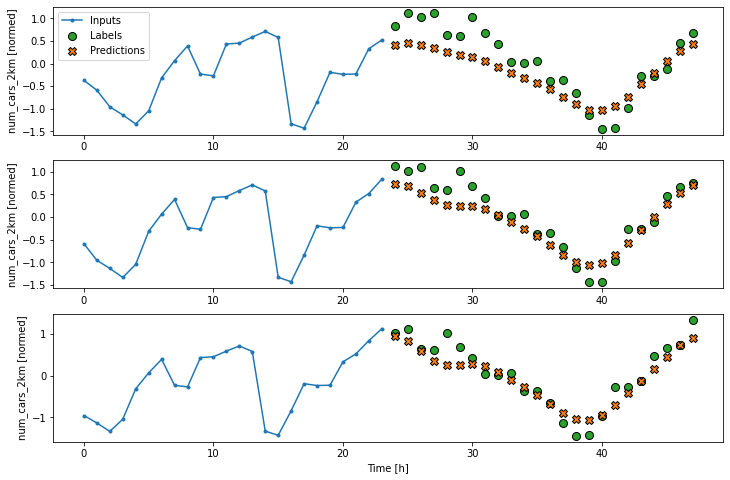

In [59]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
# multi_lstm_model = ResidualWrapper(multi_lstm_model)
history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

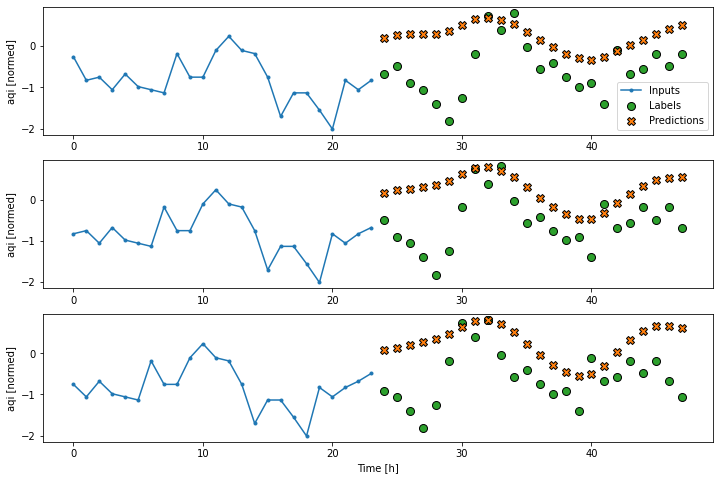

In [60]:
multi_window.plot(multi_lstm_model, plot_col='aqi')

#### Advanced Autoregressive model

The above model predict all sequence in a single time step. It might be helpful for the model to decompose the predictions into individual time steps, and feed into itself at each step and predictions made on the previous one. One advantage is that it is able to produce varying length of predictions.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


In [28]:
# ResNet
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)
    
    # The prediction for each timestep is the input
    # from the previous time step plus the delta (the small change in time series analysis)
    # calculated by the model.
    return inputs + delta

In [72]:
class LSTM_chain(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.lstm = tf.keras.layers.LSTM(units, return_sequences=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def call(self, inputs, *args, **kwargs):
    x = self.lstm(inputs)
    delta = self.dense(x)
    
    return inputs + delta

In [85]:
# the yellow block
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

  def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state
  
  def call(self, inputs, training=True):
  # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []

    # Initialize the lstm state, using state to concat the LSTM chain
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction
      # Execute one lstm step using lstm_cell
      x, state = self.lstm_cell(x, states=state,
                                training=training)
      # Convert the lstm output to a prediction.
      prediction = self.dense(x)
      # prediction, state = self.lstm_unit(state, x)
      # Add the prediction to the output
      predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])

    # residual_block = ResidualWrapper(tf.keras.Sequential([
    #   tf.keras.layers.LSTM(64, return_sequences=True),
    #   tf.keras.layers.Dense(
    #       261,
    #       # The predicted deltas should start small
    #       # So initialize the output layer with zeros
    #       kernel_initializer=tf.initializers.zeros)
    # ]))

    # predictions = residual_block(predictions)
    return predictions

feedback_model = FeedBack(units=128, out_steps=OUT_STEPS)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#### Performance

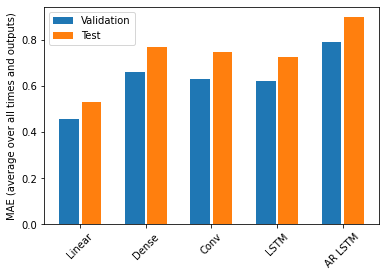

In [63]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [20]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Linear  : 0.5287
Dense   : 0.7702
Conv    : 0.7452
LSTM    : 0.8866
AR LSTM : 0.4264
